In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.io import decode_image
import torchvision.models as models
from torchvision.ops import generalized_box_iou_loss
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm.auto import tqdm
import requests
import zipfile
import pathlib
from pathlib import Path
import shutil
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from typing import Tuple, Dict, List
import sys
from timeit import default_timer as timer

# %load_ext autoreload
# %autoreload 1
# %aimport CarImageClass
import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'desktop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

IMG_SIZE = 224

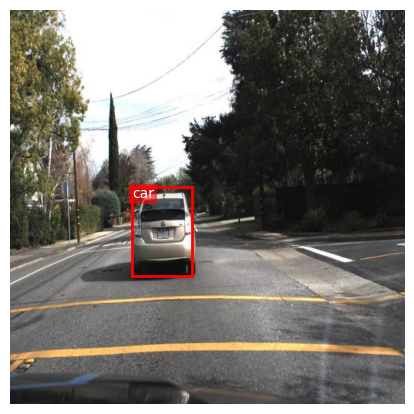

In [2]:
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=None, file_pct=0.5)

train_data.show_with_box(index=53, color='r', label=True)

In [3]:
class SingleBoxResNet18DetCls(nn.Module):
    def __init__(self, num_classes: int, img_hw: tuple[int,int], pretrained: bool=True):
        super().__init__()
        H, W = img_hw                      # e.g. (224,224); do NOT pass a scalar
        self.img_h, self.img_w = H, W
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        in_feats = m.fc.in_features
        m.fc = nn.Identity()               # expose penultimate features
        self.backbone = m

        # two small heads
        self.head_box = nn.Sequential(
            nn.Linear(in_feats, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4)
        )
        self.head_cls = nn.Sequential(
            nn.Linear(in_feats, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)    # raw logits (no softmax)
        )


    def forward(self, x):
        feat = self.backbone(x)                    # (B, in_feats)
        box_raw = self.head_box(feat)              # (B,4)
        cls_logits = self.head_cls(feat)           # (B,C)

        # keep raw logits for CE; postprocess boxes
        # map to [0,1] without hard saturation; clamp at the end
        box01 = box_raw.sigmoid()              # (B,4) in [0,1]
        x1, y1, x2, y2 = box01.unbind(-1)
        x_min = torch.minimum(x1, x2) * self.img_w
        y_min = torch.minimum(y1, y2) * self.img_h
        x_max = torch.maximum(x1, x2) * self.img_w
        y_max = torch.maximum(y1, y2) * self.img_h
        boxes = torch.stack([x_min, y_min, x_max, y_max], dim=-1)
        

        # final clamp to image bounds
        eps = 1e-4
        x1 = boxes[..., 0].clamp(0, self.img_w - eps)
        y1 = boxes[..., 1].clamp(0, self.img_h - eps)
        x2 = boxes[..., 2].clamp(0, self.img_w - eps)
        y2 = boxes[..., 3].clamp(0, self.img_h - eps)
        boxes = torch.stack([x1, y1, x2, y2], dim=-1)
        
        return {"boxes": boxes, "logits": cls_logits}
    

In [25]:
class SingleBoxResNet18DetCls_CenterCoords(nn.Module):
    def __init__(self, num_classes: int, img_hw: tuple[int,int], pretrained: bool=True):
        super().__init__()
        H, W = img_hw                      # e.g. (224,224); do NOT pass a scalar
        self.img_h, self.img_w = H, W
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        in_feats = m.fc.in_features
        m.fc = nn.Identity()               # expose penultimate features
        self.backbone = m

        # two small heads
        self.head_box = nn.Sequential(
            nn.Linear(in_feats, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4)
        )
        self.head_cls = nn.Sequential(
            nn.Linear(in_feats, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)    # raw logits (no softmax)
        )


    def forward(self, x):
        feat = self.backbone(x)
        box_raw = self.head_box(feat)     # (B,4): unconstrained
        cls_logits = self.head_cls(feat)

        # Parametrization: (cx, cy, w, h) normalized to [0,1]
        cx = box_raw[..., 0].sigmoid()
        cy = box_raw[..., 1].sigmoid()
        w  = box_raw[..., 2].sigmoid()
        h  = box_raw[..., 3].sigmoid()

        # (optional) lower bound to avoid degenerate 0-area boxes
        eps = 1e-4
        w = w.clamp_min(eps)
        h = h.clamp_min(eps)

        # Convert to XYXY in pixels for downstream use/loss that expects corners
        x1 = (cx - 0.5 * w) * self.img_w
        y1 = (cy - 0.5 * h) * self.img_h
        x2 = (cx + 0.5 * w) * self.img_w
        y2 = (cy + 0.5 * h) * self.img_h

        # final clamp
        x1 = x1.clamp(0, self.img_w - eps)
        y1 = y1.clamp(0, self.img_h - eps)
        x2 = x2.clamp(0, self.img_w - eps)
        y2 = y2.clamp(0, self.img_h - eps)
        boxes = torch.stack([x1, y1, x2, y2], dim=-1)

        return {"boxes": boxes, "logits": cls_logits, "cxcywh": torch.stack([cx, cy, w, h], -1)}

In [4]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn_bb: torch.nn.Module,
               loss_fn_class: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # put model in train mode
    model.train()

    # train loss
    train_loss_bb, train_loss_class, train_loss = 0, 0, 0

    # loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        for key in y.keys():
            y[key] = y[key].to(device)

        # forward pass
        # B, _, H, W = X.shape
        y_pred = model(X)

        # calculate loss
        loss_bb = loss_fn_bb(y_pred['boxes'].squeeze() / IMG_SIZE, y['boxes'].squeeze() / IMG_SIZE)
        train_loss_bb += loss_bb.item()

        
        loss_class = loss_fn_class(y_pred['logits'], y['labels'].squeeze(dim=1))
        train_loss_class += loss_class.item()

        train_loss += loss_bb.item() + loss_class.item() # a weighted combo can be taken later

        # Optimizer zero grad
        optimizer.zero_grad(set_to_none=True)

        # loss backward
        loss = loss_bb + loss_class
        loss.backward()

        # optimizer step
        optimizer.step()


    train_loss = train_loss / len(dataloader)
    train_loss_bb = train_loss_bb / len(dataloader)
    train_loss_class = train_loss_class / len(dataloader)
    return train_loss, {'train box loss': train_loss_bb, 'train classification loss': train_loss_class}

############################################################

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn_bb: torch.nn.Module,
              loss_fn_class: torch.nn.Module,
              device=device):
    # put model in eval mode
    model.eval()

    # test loss, test acc
    test_loss_bb, test_loss_class, test_loss = 0, 0, 0

    # turn on inference mode
    with torch.inference_mode():
        # loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to device
            X = X.to(device)
            for key in y.keys():
                y[key] = y[key].to(device)

            # forward pass
            # B, _, H, W = X.shape
            test_pred = model(X)

            # calculate loss
            loss_bb = loss_fn_bb(test_pred['boxes'].squeeze() / IMG_SIZE, y['boxes'].squeeze() / IMG_SIZE)
            test_loss_bb += loss_bb.item()

            loss_class = loss_fn_class(test_pred['logits'], y['labels'].squeeze(dim=1))
            test_loss_class += loss_class.item()

            test_loss += loss_bb.item() + loss_class.item() # a weighted combo can be taken later

    
    test_loss = test_loss / len(dataloader)
    test_loss_bb = test_loss_bb / len(dataloader)
    test_loss_class = test_loss_class / len(dataloader)
    return test_loss, {'test box loss': test_loss_bb, 'test classification loss': test_loss_class}

############################################################

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn_bb: torch.nn.Module,
          loss_fn_class: torch.nn.Module,
          epochs: int = 5,
          device=device):
    
    # create results dictionary
    results = {"train_loss": [],
               "train_loss_bb": [],
               "train_loss_class": [],
               "test_loss": [],
               "test_loss_bb": [],
               "test_loss_class": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_dict = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn_bb=loss_fn_bb,
                                loss_fn_class=loss_fn_class,
                                optimizer=optimizer,
                                device=device)
        
        test_loss, test_dict = test_step(model=model,
                                dataloader=test_dataloader,
                                loss_fn_bb=loss_fn_bb,
                                loss_fn_class=loss_fn_class,
                                device=device)
        
        if scheduler is not None:
            scheduler.step()
        
        # print(f"Epoch: {epoch}  |  Train loss: {train_loss:.4f}  |  Train box loss: {train_dict['train box loss']:.4f}  |  Train class loss: {train_dict['train classification loss']:.4f}")
        # print(f"Epoch: {epoch}  |  Test loss: {test_loss:.4f}  |  Test box loss: {test_dict['test box loss']:.4f}  |  Test class loss: {test_dict['test classification loss']:.4f}")
        print(f"Epoch: {epoch}  |  Train box loss: {train_dict['train box loss']:.4f}  |  Train class loss: {train_dict['train classification loss']:.4f}  |  Test box loss: {test_dict['test box loss']:.4f}  |  Test class loss: {test_dict['test classification loss']:.4f}")

        # update results dictionary
        results['train_loss'].append(train_loss)
        results['train_loss_bb'].append(train_dict['train box loss'])
        results['train_loss_class'].append(train_dict['train classification loss'])
        results['test_loss'].append(test_loss)
        results['test_loss_bb'].append(test_dict['test box loss'])
        results['test_loss_class'].append(test_dict['test classification loss'])

    # return results
    return results

In [5]:
def train_step_head(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device,
               bb_or_cls: str = None):
    
    if (bb_or_cls != 'bb') & (bb_or_cls != 'cls'):
        raise ValueError("bb_or_cls parameter must be 'bb' or 'cls'.")

    # put model in train mode
    model.train()

    # train loss
    train_loss = 0

    # loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        for key in y.keys():
            y[key] = y[key].to(device)

        # forward pass
        # B, _, H, W = X.shape
        y_pred = model(X)

        # calculate loss
        if bb_or_cls == 'bb':
            loss = loss_fn(y_pred['boxes'].squeeze() / IMG_SIZE, y['boxes'].squeeze() / IMG_SIZE)
        else:
            loss = loss_fn(y_pred['logits'], y['labels'].squeeze(dim=1))
        
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad(set_to_none=True)

        # loss backward
        loss.backward()

        # optimizer step
        optimizer.step()


    train_loss = train_loss / len(dataloader)
    return train_loss

############################################################

def test_step_head(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device,
              bb_or_cls: str = None):
    
    if (bb_or_cls != 'bb') & (bb_or_cls != 'cls'):
        raise ValueError("bb_or_cls parameter must be 'bb' or 'cls'.")
    
    # put model in eval mode
    model.eval()

    # test loss, test acc
    test_loss = 0

    # turn on inference mode
    with torch.inference_mode():
        # loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to device
            X = X.to(device)
            for key in y.keys():
                y[key] = y[key].to(device)

            # forward pass
            # B, _, H, W = X.shape
            test_pred = model(X)

            # calculate loss
            if bb_or_cls == 'bb':
                loss = loss_fn(test_pred['boxes'].squeeze() / IMG_SIZE, y['boxes'].squeeze() / IMG_SIZE)
            else:
                loss = loss_fn(test_pred['logits'], y['labels'].squeeze(dim=1))
            test_loss += loss.item()


    
    test_loss = test_loss / len(dataloader)
    return test_loss

############################################################

def train_head(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          device=device,
          bb_or_cls: str = None):
    
    # create results dictionary
    results = {"train_loss": [],
               "test_loss": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss = train_step_head(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device,
                                bb_or_cls=bb_or_cls)
        
        test_loss = test_step_head(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                device=device,
                                bb_or_cls=bb_or_cls)
        
        if scheduler is not None:
            scheduler.step()
        
        print(f"Epoch: {epoch}  |  Train loss: {train_loss:.4f}  |  Test loss: {test_loss:.4f}")

        # update results dictionary
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)

    # return results
    return results

Train model bounding box head for 20 epochs.



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0  |  Train loss: 0.1188  |  Test loss: 0.1174
Epoch: 1  |  Train loss: 0.1054  |  Test loss: 0.1185
Epoch: 2  |  Train loss: 0.1026  |  Test loss: 0.1129
Epoch: 3  |  Train loss: 0.1023  |  Test loss: 0.1148
Epoch: 4  |  Train loss: 0.1001  |  Test loss: 0.1124
Epoch: 5  |  Train loss: 0.1011  |  Test loss: 0.1116
Epoch: 6  |  Train loss: 0.1001  |  Test loss: 0.1133
Epoch: 7  |  Train loss: 0.0994  |  Test loss: 0.1114
Epoch: 8  |  Train loss: 0.0993  |  Test loss: 0.1104
Epoch: 9  |  Train loss: 0.0992  |  Test loss: 0.1108
Epoch: 10  |  Train loss: 0.0996  |  Test loss: 0.1109
Epoch: 11  |  Train loss: 0.0996  |  Test loss: 0.1104
Epoch: 12  |  Train loss: 0.0991  |  Test loss: 0.1103
Epoch: 13  |  Train loss: 0.0988  |  Test loss: 0.1111
Epoch: 14  |  Train loss: 0.0988  |  Test loss: 0.1111
Epoch: 15  |  Train loss: 0.0986  |  Test loss: 0.1106
Epoch: 16  |  Train loss: 0.0987  |  Test loss: 0.1104
Epoch: 17  |  Train loss: 0.0981  |  Test loss: 0.1108
Epoch: 18  |  Train 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0  |  Train loss: 0.7619  |  Test loss: 0.5882
Epoch: 1  |  Train loss: 0.5732  |  Test loss: 0.4684
Epoch: 2  |  Train loss: 0.4975  |  Test loss: 0.4367
Epoch: 3  |  Train loss: 0.4598  |  Test loss: 0.3211
Epoch: 4  |  Train loss: 0.3496  |  Test loss: 0.3121
Epoch: 5  |  Train loss: 0.3397  |  Test loss: 0.2610
Epoch: 6  |  Train loss: 0.3007  |  Test loss: 0.2396
Epoch: 7  |  Train loss: 0.2848  |  Test loss: 0.2347
Epoch: 8  |  Train loss: 0.2636  |  Test loss: 0.2106
Epoch: 9  |  Train loss: 0.2426  |  Test loss: 0.2298
Epoch: 10  |  Train loss: 0.2221  |  Test loss: 0.1941
Epoch: 11  |  Train loss: 0.2324  |  Test loss: 0.1875
Epoch: 12  |  Train loss: 0.2036  |  Test loss: 0.1830
Epoch: 13  |  Train loss: 0.1918  |  Test loss: 0.2040
Epoch: 14  |  Train loss: 0.1930  |  Test loss: 0.1724
Epoch: 15  |  Train loss: 0.1875  |  Test loss: 0.2093
Epoch: 16  |  Train loss: 0.1731  |  Test loss: 0.1633
Epoch: 17  |  Train loss: 0.1859  |  Test loss: 0.1662
Epoch: 18  |  Train 

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0  |  Train box loss: 0.0980  |  Train class loss: 0.1550  |  Test box loss: 0.1112  |  Test class loss: 0.1366
Epoch: 1  |  Train box loss: 0.0982  |  Train class loss: 0.1505  |  Test box loss: 0.1113  |  Test class loss: 0.1338
Epoch: 2  |  Train box loss: 0.0982  |  Train class loss: 0.1528  |  Test box loss: 0.1115  |  Test class loss: 0.1360
Epoch: 3  |  Train box loss: 0.0981  |  Train class loss: 0.1415  |  Test box loss: 0.1113  |  Test class loss: 0.1290
Epoch: 4  |  Train box loss: 0.0983  |  Train class loss: 0.1530  |  Test box loss: 0.1113  |  Test class loss: 0.1305
Epoch: 5  |  Train box loss: 0.0979  |  Train class loss: 0.1238  |  Test box loss: 0.1113  |  Test class loss: 0.1285
Epoch: 6  |  Train box loss: 0.0981  |  Train class loss: 0.1503  |  Test box loss: 0.1113  |  Test class loss: 0.1305
Epoch: 7  |  Train box loss: 0.0983  |  Train class loss: 0.1241  |  Test box loss: 0.1114  |  Test class loss: 0.1285
Epoch: 8  |  Train box loss: 0.0983  |  Train cl

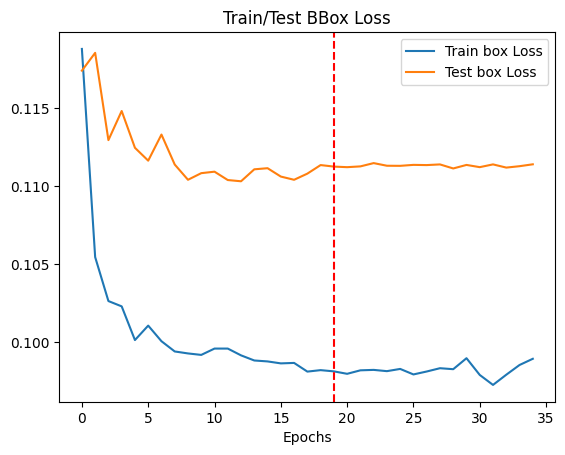

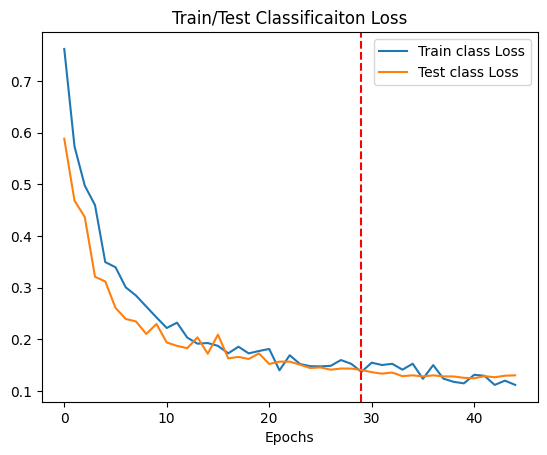

In [8]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((IMG_SIZE, IMG_SIZE)),                        # pick a fixed size for batching
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


# training/validation/testing data
train_set = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=train_tfms, file_pct=1)
test_data = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=test_tfms, file_pct=1)

train_data, val_data = CarImageClass.make_train_test_split(full_set=train_set, test_size=0.25, transform_train=train_tfms, transform_test=test_tfms)

BATCH_SIZE = 32
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              #num_workers=NUM_WORKERS,
                              )

val_dataloader = DataLoader(val_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

# start timer
start_time = timer()

# model instantiation
model_0 = SingleBoxResNet18DetCls(3, (IMG_SIZE, IMG_SIZE)).to(device)

# create weights for cross entropy loss
counts = torch.zeros(len(train_data.classes))
i = 0
for name in train_data.classes:
    counts[i] = train_data.annotate_df['class'].value_counts()[name]
    i +=1

weights = (1.0 / counts.clamp_min(1).sqrt())
weights = weights / weights.mean()



# Freeze all parameters in the backbone and classifier head
for param in model_0.backbone.parameters():
    param.requires_grad = False
for param in model_0.head_cls.parameters():
    param.requires_grad = False



# setup loss function
loss_fn_bb = nn.L1Loss()
loss_fn_cls = nn.CrossEntropyLoss(weight=weights.to(device))

# Create an optimizer that only learns the head bbox parameters
optimizer_bb = torch.optim.Adam(model_0.head_box.parameters(), lr=1e-3)
scheduler_bb = StepLR(optimizer_bb, step_size=2, gamma=0.6)


# train model 0 heads first
# number of epochs
NUM_EPOCHS_H_bb = 20


print(f"Train model bounding box head for {NUM_EPOCHS_H_bb} epochs.")
print()
model_0_results_head_bb = train_head(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer_bb,
                        scheduler=scheduler_bb,
                        loss_fn=loss_fn_bb,
                        epochs=NUM_EPOCHS_H_bb,
                        bb_or_cls='bb')


# Create an optimizer that only learns the head classifier parameters
optimizer_cls = torch.optim.Adam(model_0.head_cls.parameters(), lr=1e-3)
scheduler_cls = StepLR(optimizer_cls, step_size=1, gamma=0.9)

# Freeze all parameters in the bounding box head
for param in model_0.head_box.parameters():
    param.requires_grad = False

# Unfreeze all parameters in the classifier head
for param in model_0.head_cls.parameters():
    param.requires_grad = True


# number of epochs
NUM_EPOCHS_H_cls = 30

print()
print(f"Train model classifier head for {NUM_EPOCHS_H_cls} epochs.")
print()
model_0_results_head_cls = train_head(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer_cls,
                        scheduler=scheduler_cls,
                        loss_fn=loss_fn_cls,
                        epochs=NUM_EPOCHS_H_cls,
                        bb_or_cls='cls')


# Unfreeze all model parameters
for param in model_0.parameters():
    param.requires_grad = True

# Create a new optimizer for fine-tuning the whole model
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-6)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

# train model 0 whole
# number of epochs
NUM_EPOCHS_W = 15
print()
print(f"Train entire model for {NUM_EPOCHS_W} epochs.")
print()
model_0_results_whole = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn_bb=loss_fn_bb,
                        loss_fn_class=loss_fn_cls,
                        epochs=NUM_EPOCHS_W)

# end timer and print
end_time = timer()
print()
print(f"Total training time: {end_time - start_time:.3f} seconds")
print()

plt.plot(range(0, NUM_EPOCHS_H_bb+NUM_EPOCHS_W), model_0_results_head_bb["train_loss"] + model_0_results_whole["train_loss_bb"], label="Train box Loss")
plt.plot(range(0, NUM_EPOCHS_H_bb+NUM_EPOCHS_W), model_0_results_head_bb["test_loss"] + model_0_results_whole["test_loss_bb"], label="Test box Loss")
plt.title("Train/Test BBox Loss")
plt.xlabel("Epochs")
plt.axvline(x=NUM_EPOCHS_H_bb-1, linestyle='--', linewidth=1.5, color='r')
plt.legend()
# plt.ylim(0.08,0.14)

plt.show()


plt.plot(range(0, NUM_EPOCHS_H_cls+NUM_EPOCHS_W), model_0_results_head_cls["train_loss"] + model_0_results_whole["train_loss_class"], label="Train class Loss")
plt.plot(range(0, NUM_EPOCHS_H_cls+NUM_EPOCHS_W), model_0_results_head_cls["test_loss"] + model_0_results_whole["test_loss_class"], label="Test class Loss")
plt.title("Train/Test Classificaiton Loss")
plt.xlabel("Epochs")
plt.axvline(x=NUM_EPOCHS_H_cls-1, linestyle='--', linewidth=1.5, color='r')
plt.legend()
# plt.ylim(0,0.75)

plt.show()

In [9]:
model_0.eval()

# turn on inference mode
true_class = []
pred_class = []
with torch.inference_mode():
    # loop through dataloader batches
    for batch, (X, y) in enumerate(test_dataloader):
        # send data to device
        X = X.to(device)
        for key in y.keys():
            y[key] = y[key].to(device)

        # forward pass
        # B, _, H, W = X.shape
        b_test_pred_class = (model_0(X)['logits'].argmax(dim=1)).tolist()
        b_test_true_class = y['labels'].squeeze().tolist()

        true_class.extend(b_test_true_class)
        pred_class.extend(b_test_pred_class)


df_pred = pd.DataFrame({'true class': true_class, 'predicted class': pred_class})

inverse_map = {v: k for k, v in test_data.class_to_idx.items()}

df_pred['true class'] = df_pred['true class'].map(inverse_map)
df_pred['predicted class'] = df_pred['predicted class'].map(inverse_map)




print(f"There are a total of {len(df_pred[df_pred['true class'] == 'car'])} cars in the dataset.")
print()
print(df_pred[(df_pred['true class'] == 'car') & (df_pred['predicted class'] != 'car')])
print()
print(f"Cars were classified correctly {len(df_pred[(df_pred['true class'] == 'car') & (df_pred['predicted class'] == 'car')]) / len(df_pred[df_pred['true class'] == 'car']) * 100:.2f}% of the time.")

print()
print(f"There are a total of {len(df_pred[df_pred['true class'] == 'pedestrian'])} pedestrians in the dataset.")
print()
print(df_pred[(df_pred['true class'] == 'pedestrian') & (df_pred['predicted class'] != 'pedestrian')])
print()
print(f"Pedestrians were classified correctly {len(df_pred[(df_pred['true class'] == 'pedestrian') & (df_pred['predicted class'] == 'pedestrian')]) / len(df_pred[df_pred['true class'] == 'pedestrian']) * 100:.2f}% of the time.")

print()
print(f"There are a total of {len(df_pred[df_pred['true class'] == 'truck'])} trucks in the dataset.")
print()
print(df_pred[(df_pred['true class'] == 'truck') & (df_pred['predicted class'] != 'truck')])
print()
print(f"Trucks were classified correctly {len(df_pred[(df_pred['true class'] == 'truck') & (df_pred['predicted class'] == 'truck')]) / len(df_pred[df_pred['true class'] == 'truck']) * 100:.2f}% of the time.")

There are a total of 577 cars in the dataset.

    true class predicted class
87         car           truck
88         car           truck
90         car           truck
92         car           truck
93         car           truck
107        car           truck
140        car      pedestrian
198        car      pedestrian
316        car           truck
457        car           truck
482        car           truck
502        car           truck
503        car           truck
505        car           truck
506        car           truck
508        car           truck
555        car           truck
556        car           truck
576        car           truck
577        car           truck

Cars were classified correctly 96.53% of the time.

There are a total of 12 pedestrians in the dataset.

     true class predicted class
392  pedestrian             car
393  pedestrian             car

Pedestrians were classified correctly 83.33% of the time.

There are a total of 28 trucks in the da

Train model bounding box head for 20 epochs.



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0  |  Train loss: 0.2412  |  Test loss: 0.2067
Epoch: 1  |  Train loss: 0.2198  |  Test loss: 0.2015
Epoch: 2  |  Train loss: 0.2186  |  Test loss: 0.2008
Epoch: 3  |  Train loss: 0.2194  |  Test loss: 0.2010
Epoch: 4  |  Train loss: 0.2169  |  Test loss: 0.1991
Epoch: 5  |  Train loss: 0.2174  |  Test loss: 0.1993
Epoch: 6  |  Train loss: 0.2171  |  Test loss: 0.1988
Epoch: 7  |  Train loss: 0.2148  |  Test loss: 0.2013
Epoch: 8  |  Train loss: 0.2158  |  Test loss: 0.1988
Epoch: 9  |  Train loss: 0.2161  |  Test loss: 0.1987
Epoch: 10  |  Train loss: 0.2176  |  Test loss: 0.1987
Epoch: 11  |  Train loss: 0.2150  |  Test loss: 0.1987
Epoch: 12  |  Train loss: 0.2160  |  Test loss: 0.1987
Epoch: 13  |  Train loss: 0.2154  |  Test loss: 0.1987
Epoch: 14  |  Train loss: 0.2160  |  Test loss: 0.1989
Epoch: 15  |  Train loss: 0.2149  |  Test loss: 0.1986
Epoch: 16  |  Train loss: 0.2158  |  Test loss: 0.1985
Epoch: 17  |  Train loss: 0.2168  |  Test loss: 0.1987
Epoch: 18  |  Train 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0  |  Train loss: 0.8695  |  Test loss: 0.6863
Epoch: 1  |  Train loss: 0.6722  |  Test loss: 0.6111
Epoch: 2  |  Train loss: 0.6115  |  Test loss: 0.6119
Epoch: 3  |  Train loss: 0.5400  |  Test loss: 0.4723
Epoch: 4  |  Train loss: 0.4920  |  Test loss: 0.4480
Epoch: 5  |  Train loss: 0.4358  |  Test loss: 0.3954
Epoch: 6  |  Train loss: 0.3965  |  Test loss: 0.3931
Epoch: 7  |  Train loss: 0.3719  |  Test loss: 0.3386
Epoch: 8  |  Train loss: 0.3512  |  Test loss: 0.3108
Epoch: 9  |  Train loss: 0.3353  |  Test loss: 0.3300
Epoch: 10  |  Train loss: 0.3353  |  Test loss: 0.3144
Epoch: 11  |  Train loss: 0.3013  |  Test loss: 0.3227
Epoch: 12  |  Train loss: 0.2995  |  Test loss: 0.2859
Epoch: 13  |  Train loss: 0.2594  |  Test loss: 0.2752
Epoch: 14  |  Train loss: 0.2777  |  Test loss: 0.2735
Epoch: 15  |  Train loss: 0.2785  |  Test loss: 0.2996
Epoch: 16  |  Train loss: 0.2541  |  Test loss: 0.2559
Epoch: 17  |  Train loss: 0.2557  |  Test loss: 0.2566
Epoch: 18  |  Train 

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0  |  Train box loss: 0.2177  |  Train class loss: 0.2082  |  Test box loss: 0.1985  |  Test class loss: 0.2200
Epoch: 1  |  Train box loss: 0.2144  |  Train class loss: 0.2111  |  Test box loss: 0.1985  |  Test class loss: 0.2130
Epoch: 2  |  Train box loss: 0.2192  |  Train class loss: 0.2001  |  Test box loss: 0.1985  |  Test class loss: 0.2109
Epoch: 3  |  Train box loss: 0.2141  |  Train class loss: 0.2018  |  Test box loss: 0.1986  |  Test class loss: 0.2074
Epoch: 4  |  Train box loss: 0.2155  |  Train class loss: 0.1922  |  Test box loss: 0.1986  |  Test class loss: 0.2051
Epoch: 5  |  Train box loss: 0.2162  |  Train class loss: 0.1886  |  Test box loss: 0.1986  |  Test class loss: 0.2016
Epoch: 6  |  Train box loss: 0.2171  |  Train class loss: 0.1763  |  Test box loss: 0.1986  |  Test class loss: 0.2038
Epoch: 7  |  Train box loss: 0.2152  |  Train class loss: 0.1806  |  Test box loss: 0.1985  |  Test class loss: 0.2005
Epoch: 8  |  Train box loss: 0.2153  |  Train cl

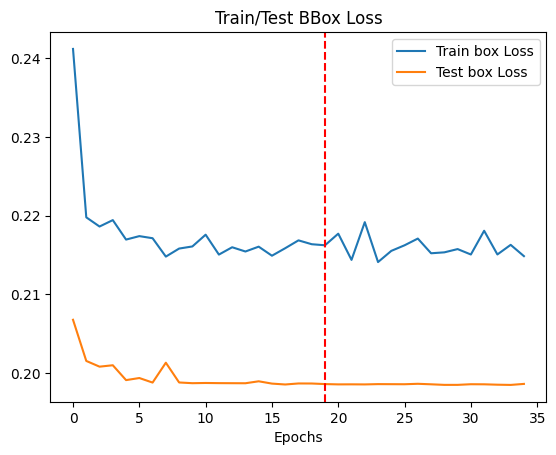

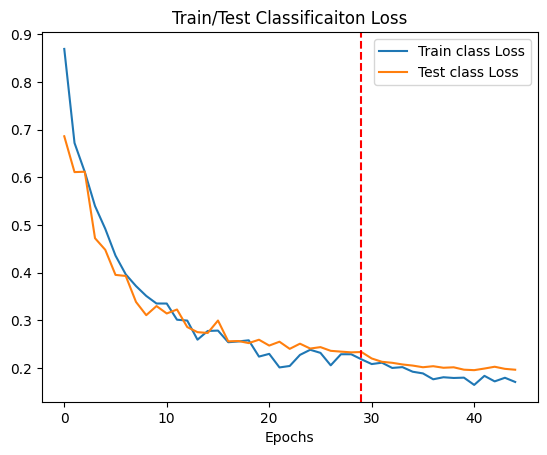

In [26]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.ConvertBoundingBoxFormat('CXCYWH'),
    v2.Resize((IMG_SIZE, IMG_SIZE)),                        # pick a fixed size for batching
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.ConvertBoundingBoxFormat('CXCYWH'),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


# training/validation/testing data
train_set = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=train_tfms, file_pct=1)
test_data = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=test_tfms, file_pct=1)

train_data, val_data = CarImageClass.make_train_test_split(full_set=train_set, test_size=0.25, transform_train=train_tfms, transform_test=test_tfms)

BATCH_SIZE = 32
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              #num_workers=NUM_WORKERS,
                              )

val_dataloader = DataLoader(val_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

# start timer
start_time = timer()

# model instantiation
model_1 = SingleBoxResNet18DetCls_CenterCoords(3, (IMG_SIZE, IMG_SIZE)).to(device)

# create weights for cross entropy loss
counts = torch.zeros(len(train_data.classes))
i = 0
for name in train_data.classes:
    counts[i] = train_data.annotate_df['class'].value_counts()[name]
    i +=1

weights = (1.0 / counts.clamp_min(1).sqrt())
weights = weights / weights.mean()



# Freeze all parameters in the backbone and classifier head
for param in model_1.backbone.parameters():
    param.requires_grad = False
for param in model_1.head_cls.parameters():
    param.requires_grad = False



# setup loss function
loss_fn_bb = nn.L1Loss()
loss_fn_cls = nn.CrossEntropyLoss(weight=weights.to(device))

# Create an optimizer that only learns the head bbox parameters
optimizer_bb = torch.optim.Adam(model_1.head_box.parameters(), lr=1e-3)
scheduler_bb = StepLR(optimizer_bb, step_size=2, gamma=0.6)


# train model 0 heads first
# number of epochs
NUM_EPOCHS_H_bb = 20


print(f"Train model bounding box head for {NUM_EPOCHS_H_bb} epochs.")
print()
model_1_results_head_bb = train_head(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer_bb,
                        scheduler=scheduler_bb,
                        loss_fn=loss_fn_bb,
                        epochs=NUM_EPOCHS_H_bb,
                        bb_or_cls='bb')


# Create an optimizer that only learns the head classifier parameters
optimizer_cls = torch.optim.Adam(model_1.head_cls.parameters(), lr=1e-3)
scheduler_cls = StepLR(optimizer_cls, step_size=1, gamma=0.9)

# Freeze all parameters in the bounding box head
for param in model_1.head_box.parameters():
    param.requires_grad = False

# Unfreeze all parameters in the classifier head
for param in model_1.head_cls.parameters():
    param.requires_grad = True


# number of epochs
NUM_EPOCHS_H_cls = 30

print()
print(f"Train model classifier head for {NUM_EPOCHS_H_cls} epochs.")
print()
model_1_results_head_cls = train_head(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer_cls,
                        scheduler=scheduler_cls,
                        loss_fn=loss_fn_cls,
                        epochs=NUM_EPOCHS_H_cls,
                        bb_or_cls='cls')


# Unfreeze all model parameters
for param in model_1.parameters():
    param.requires_grad = True

# Create a new optimizer for fine-tuning the whole model
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-6)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

# train model 0 whole
# number of epochs
NUM_EPOCHS_W = 15
print()
print(f"Train entire model for {NUM_EPOCHS_W} epochs.")
print()
model_1_results_whole = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn_bb=loss_fn_bb,
                        loss_fn_class=loss_fn_cls,
                        epochs=NUM_EPOCHS_W)

# end timer and print
end_time = timer()
print()
print(f"Total training time: {end_time - start_time:.3f} seconds")
print()

plt.plot(range(0, NUM_EPOCHS_H_bb+NUM_EPOCHS_W), model_1_results_head_bb["train_loss"] + model_1_results_whole["train_loss_bb"], label="Train box Loss")
plt.plot(range(0, NUM_EPOCHS_H_bb+NUM_EPOCHS_W), model_1_results_head_bb["test_loss"] + model_1_results_whole["test_loss_bb"], label="Test box Loss")
plt.title("Train/Test BBox Loss")
plt.xlabel("Epochs")
plt.axvline(x=NUM_EPOCHS_H_bb-1, linestyle='--', linewidth=1.5, color='r')
plt.legend()
# plt.ylim(0.08,0.14)

plt.show()


plt.plot(range(0, NUM_EPOCHS_H_cls+NUM_EPOCHS_W), model_1_results_head_cls["train_loss"] + model_1_results_whole["train_loss_class"], label="Train class Loss")
plt.plot(range(0, NUM_EPOCHS_H_cls+NUM_EPOCHS_W), model_1_results_head_cls["test_loss"] + model_1_results_whole["test_loss_class"], label="Test class Loss")
plt.title("Train/Test Classificaiton Loss")
plt.xlabel("Epochs")
plt.axvline(x=NUM_EPOCHS_H_cls-1, linestyle='--', linewidth=1.5, color='r')
plt.legend()
# plt.ylim(0,0.75)

plt.show()

In [ ]:
# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path(r"C:\self-driving-car\models")
MODEL_PATH.mkdir(parents=False, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "OneObj_BBoxClassifier_10132025.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

In [ ]:
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_0 = SingleBoxResNet18DetCls(3, (IMG_SIZE, IMG_SIZE))

# Load in the saved state_dict()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to device
loaded_model_0 = loaded_model_0.to(device)

In [10]:
def show_with_box(img_plus_target,
                  color: str = "C0",
                  lw: int = 2,
                  label: bool = False,
                  pred_box: bool = False,
                  bbox_pred: torch.Tensor = torch.zeros((1,4)),
                  label_pred: str = None
                  ):
        
        # convert the image to a numpy array
        img, target = img_plus_target

        if isinstance(img, Image.Image):
            arr = np.array(img)
        elif isinstance(img, np.ndarray):
            arr = img
            if arr.ndim == 3 and arr.shape[0] in (1, 3) and arr.shape[2] not in (1, 3):
                arr = np.transpose(arr, (1, 2, 0))
        elif isinstance(img, torch.Tensor):
            t = img.detach().cpu()
            if t.ndim == 3 and t.shape[0] in (1, 3):  # CHW -> HWC
                t = t.permute(1, 2, 0)
            arr = t.numpy()
        else:
            raise TypeError(f"Unsupported image type: {type(img)}")

        if arr.dtype.kind == "f" and arr.max() <= 1.0:
            arr = (arr * 255.0).clip(0, 255).astype(np.uint8)
        elif arr.dtype != np.uint8:
            arr = arr.astype(np.uint8)
        

        # plot image
        H, W = arr.shape[:2]
        dpi = 100
        fig, ax = plt.subplots(figsize=(W/dpi, H/dpi), dpi=dpi)
        ax.imshow(arr)  # origin='upper' -> y downward, matches image coords

        for i in range(len(target['labels'])):

            # basic sanity + clipping
            x_min = target['boxes'][i, 0]
            y_min = target['boxes'][i, 1]
            x_max = target['boxes'][i, 2]
            y_max = target['boxes'][i, 3]
            x_min, y_min = max(0.0, x_min), max(0.0, y_min)
            x_max, y_max = min(W - 1, x_max), min(H - 1, y_max)
            if not (x_max > x_min and y_max > y_min):
                # raise ValueError("Degenerate or inverted box after clipping.")
                continue

            
            rect = Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=lw,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)
            if label:
                label_dict = {'car': 0, 'truck': 2, 'pedestrian': 1}
                im_label_masked = target['labels'][i]
                im_label = list(label_dict.keys())[list(label_dict.values()).index(im_label_masked)]
                ax.text(
                    x_min, y_min,
                    str(im_label),
                    fontsize=10,
                    color="white",
                    va="bottom",
                    ha="right",
                    bbox=dict(facecolor=color, alpha=0.6, pad=2, edgecolor="none"),
                )
        
        if pred_box == True:
            for i in range(len(bbox_pred)):
                x_min = bbox_pred[i, 0]
                y_min = bbox_pred[i, 1]
                x_max = bbox_pred[i, 2]
                y_max = bbox_pred[i, 3]
                x_min, y_min = max(0.0, x_min), max(0.0, y_min)
                x_max, y_max = min(W - 1, x_max), min(H - 1, y_max)
                if not (x_max > x_min and y_max > y_min):
                    # raise ValueError("Degenerate or inverted box after clipping.")
                    continue

                
                rect = Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=lw,
                    edgecolor='g',
                    facecolor="none",
                )
                ax.add_patch(rect)

            if label_pred is not None:
                ax.text(
                        x_max, y_max,
                        label_pred,
                        fontsize=10,
                        color="white",
                        va="top",
                        ha="left",
                        bbox=dict(facecolor='g', alpha=0.6, pad=2, edgecolor="none"),
                    )
        
        ax.axis("off")

        plt.close(fig)
        return fig

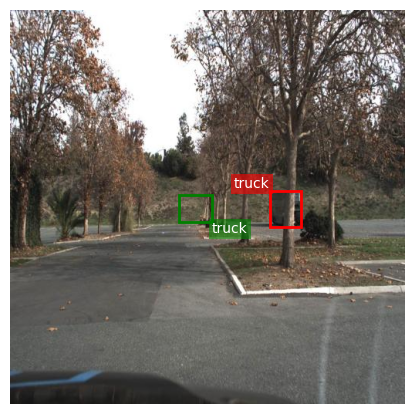

In [24]:
new_imgs = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=test_tfms, file_pct=1)
test_set = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=None, file_pct=1)

BATCH_SIZE = 1
# Create DataLoader's
new_dataloader = DataLoader(new_imgs, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              #num_workers=NUM_WORKERS,
                              )

rand_index = np.random.randint(0, len(new_imgs))

new = new_dataloader.dataset[rand_index]

pred_dict = model_0(new[0].unsqueeze(dim=0).to(device))
pred_dict['boxes'] = pred_dict['boxes'].to('cpu')
pred_dict['logits'] = pred_dict['logits'].to('cpu')

predbox = pred_dict['boxes'].detach() * (512 / IMG_SIZE)
pred_label = list(test_set.class_to_idx.keys())[list(test_set.class_to_idx.values()).index(torch.argmax(pred_dict['logits']))]


show_with_box(test_set[new[1]['image_id']], color='r', label=True, pred_box=True, bbox_pred=predbox, label_pred=pred_label)

In [111]:
BATCH_SIZE = 16
# Create DataLoader's
new_dataloader = DataLoader(new_imgs, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              #num_workers=NUM_WORKERS,
                              )

results = test_step(model=model_0,
          dataloader=new_dataloader,
          loss_fn_bb=loss_fn_bb,
          loss_fn_class=loss_fn_class,
          device=device)

In [112]:
results

(tensor(0.3562),
 {'test box loss': 0.07388612451270604,
  'test classification loss': 0.2823192164457093})

In [ ]:
model_0.eval()

# turn on inference mode
true_class = []
pred_class = []
with torch.inference_mode():
    # loop through dataloader batches
    for batch, (X, y) in enumerate(new_dataloader):
        # send data to device
        X = X.to(device)
        for key in y.keys():
            y[key] = y[key].to(device)

        # forward pass
        # B, _, H, W = X.shape
        b_test_pred_class = (model_0(X)['logits'].argmax(dim=1)).tolist()
        b_test_true_class = y['labels'].squeeze().tolist()

        true_class.extend(b_test_true_class)
        pred_class.extend(b_test_pred_class)


df_pred = pd.DataFrame({'true class': true_class, 'predicted class': pred_class})

inverse_map = {v: k for k, v in new_imgs.class_to_idx.items()}

df_pred['true class'] = df_pred['true class'].map(inverse_map)
df_pred['predicted class'] = df_pred['predicted class'].map(inverse_map)

In [183]:
print(f"There are a total of {len(df_pred[df_pred['true class'] == 'car'])} cars in the dataset.")
print()
print(df_pred[(df_pred['true class'] == 'car') & (df_pred['predicted class'] != 'car')])
print()
print(f"Cars were classified correctly {len(df_pred[(df_pred['true class'] == 'car') & (df_pred['predicted class'] == 'car')]) / len(df_pred[df_pred['true class'] == 'car']) * 100:.2f}% of the time.")

print()
print(f"There are a total of {len(df_pred[df_pred['true class'] == 'pedestrian'])} pedestrians in the dataset.")
print()
print(df_pred[(df_pred['true class'] == 'pedestrian') & (df_pred['predicted class'] != 'pedestrian')])
print()
print(f"Pedestrians were classified correctly {len(df_pred[(df_pred['true class'] == 'pedestrian') & (df_pred['predicted class'] == 'pedestrian')]) / len(df_pred[df_pred['true class'] == 'pedestrian']) * 100:.2f}% of the time.")

print()
print(f"There are a total of {len(df_pred[df_pred['true class'] == 'truck'])} trucks in the dataset.")
print()
print(df_pred[(df_pred['true class'] == 'truck') & (df_pred['predicted class'] != 'truck')])
print()
print(f"Trucks were classified correctly {len(df_pred[(df_pred['true class'] == 'truck') & (df_pred['predicted class'] == 'truck')]) / len(df_pred[df_pred['true class'] == 'truck']) * 100:.2f}% of the time.")

There are a total of 577 cars in the dataset.

    true class predicted class
198        car      pedestrian
463        car           truck
501        car           truck
555        car           truck

Cars were classified correctly 99.31% of the time.

There are a total of 12 pedestrians in the dataset.

     true class predicted class
196  pedestrian             car
197  pedestrian             car
392  pedestrian             car
393  pedestrian             car

Pedestrians were classified correctly 66.67% of the time.

There are a total of 28 trucks in the dataset.

    true class predicted class
112      truck             car
113      truck             car
363      truck             car
364      truck             car
385      truck             car
507      truck             car
582      truck             car

Trucks were classified correctly 75.00% of the time.


In [166]:
df_pred = pd.DataFrame({'true class': true_class, 'predicted class': pred_class})

inverse_map = {v: k for k, v in new_imgs.class_to_idx.items()}

df_pred['true class'] = df_pred['true class'].map(inverse_map)
df_pred['predicted class'] = df_pred['predicted class'].map(inverse_map)

df_pred

,true class,predicted class
0,car,car
1,car,car
2,car,car
3,car,car
4,car,car
...,...,...
612,car,car
613,car,car
614,car,car
615,car,car


In [163]:
new_imgs.class_to_idx

{'car': 1, 'pedestrian': 2, 'truck': 3}

In [125]:
new_imgs.class_to_idx

{'car': 1, 'pedestrian': 2, 'truck': 3}

In [129]:
pred_labels = list(new_imgs.class_to_idx.keys())[list(new_imgs.class_to_idx.values()).index(torch.argmax(test_pred_logits) + 1)]

pred_labels

ValueError: tensor(13) is not in list

In [133]:
for i in range(len(test_pred_logits)):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [131]:
torch.argmax(test_pred_logits)

tensor(12)

In [134]:
test_pred_logits

tensor([[ 5.5156, -1.5767, -1.9722],
        [ 5.1538, -2.0110, -1.5123],
        [ 5.1104, -2.0533, -1.4560],
        [ 4.5690, -1.8821, -1.7185],
        [ 6.2400, -2.2357, -2.6258],
        [ 5.0819, -2.0176, -2.0717],
        [ 5.1782, -2.0917, -2.0923],
        [ 4.7561, -2.0740, -1.5771],
        [ 4.7175, -2.0677, -1.5343],
        [ 5.9770, -2.3667, -2.2070],
        [ 5.0926, -2.2077, -1.5717],
        [ 4.8465, -1.5037, -1.9404],
        [ 5.2006, -1.9461, -1.9905],
        [ 5.2340, -1.9745, -1.9771],
        [ 5.4185, -1.8510, -1.9685],
        [ 5.5152, -1.9135, -1.9711]])

In [136]:
df_labels = pd.DataFrame(columns=['true class', 'predicted class'])

df_labels

,true class,predicted class
